# Installation des bibliothèques

In [ ]:
!pip install yfinance pandas_datareader
!pip install matplotlib seaborn

# Financial Performance analysis

In [ ]:
import yfinance as yf
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

In [ ]:
# Companies list
companies = {
    "LVMH": "MC.PA",
    "Kering": "KER.PA",
    "Hermes": "RMS.PA",
    "L'Oreal": "OR.PA",
    "Pernod Ricard": "RI.PA"
}

# Manual equity values (in million euros) for fallback
manual_equity_data = {
    'LVMH': {
        2021: 48909, 2022: 56604, 2023: 62701, 2024: 69287
    },
    'Kering': {
        2021: 16251, 2022: 15575, 2023: 17328, 2024: 17021
    },
    'Hermes': {
        2021: 9417, 2022: 11922, 2023: 14038, 2024: 17330
    },
    "L'Oreal": {
        2021: 23593, 2022: 27186, 2023: 29082, 2024: 33130
    },
    'Pernod Ricard': {
        2021: 14944, 2022: 15717, 2023: 16715, 2024: 16797
    }
}

start_year = 2021
end_year = 2024

def get_financial_data(ticker_symbol):
    ticker = yf.Ticker(ticker_symbol)
    try:
        income_stmt = ticker.financials.T
        balance_sheet = ticker.balance_sheet.T
    except:
        return None, None
    return income_stmt, balance_sheet

# Extract data
data = []
for company, ticker in companies.items():
    income, balance = get_financial_data(ticker)
    if income is None or balance is None:
        continue
    for date in income.index:
        year = date.year
        if start_year <= year <= end_year:
            equity_value = balance.loc[date].get("Total Stockholder Equity", None)
            if equity_value is None:
                equity_value = manual_equity_data.get(company, {}).get(year, None)
                equity_value = equity_value * 1e6 if equity_value is not None else None
            row = {
                "Company": company,
                "Dates": year,
                "Revenue (M€)": income.loc[date].get("Total Revenue", None) / 1e6,
                "Net Income (M€)": income.loc[date].get("Net Income", None) / 1e6,
                "Equity (M€)": equity_value / 1e6 if equity_value is not None else None,
                "Assets (M€)": balance.loc[date].get("Total Assets", None) / 1e6,
                "Liabilities (M€)": balance.loc[date].get("Total Liabilities Net Minority Interest", None) / 1e6,
                "Current Assets (M€)": balance.loc[date].get("Current Assets", None) / 1e6,
                "Current Liabilities (M€)": balance.loc[date].get("Current Liabilities", None) / 1e6
            }
            data.append(row)

# Create DataFrame
df = pd.DataFrame(data)

# Display raw financial data
display(df.sort_values(by=["Company", "Dates"]))

# Calculate ratios
def calculate_ratios(row):
    try:
        roe = (row['Net Income (M€)'] / row['Equity (M€)']) * 100
        roa = (row['Net Income (M€)'] / row['Assets (M€)']) * 100
        margin = (row['Net Income (M€)'] / row['Revenue (M€)']) * 100
        debt = (row['Liabilities (M€)'] / row['Equity (M€)']) * 100
        current_ratio = row['Current Assets (M€)'] / row['Current Liabilities (M€)']
        return pd.Series([roe, roa, margin, debt, current_ratio])
    except:
        return pd.Series([None]*5)

df[['ROE (%)', 'ROA (%)', 'Net Profit Margin (%)', 'Endettement (%)', 'Current Ratio']] = df.apply(calculate_ratios, axis=1)

years_available = sorted(df['Dates'].dropna().unique())
companies_available = sorted(df['Company'].dropna().unique())

# Bar chart – Revenue Comparison
@interact(
    year=widgets.Dropdown(options=years_available, description='Année'),
    companies=widgets.SelectMultiple(options=companies_available, description='Entreprises', value=companies_available)
)
def revenue_comparison(year, companies):
    data_ = df[(df['Dates'] == year) & (df['Company'].isin(companies))]
    plt.figure(figsize=(10, 5))
    sns.barplot(data=data_, x='Company', y='Revenue (M€)', palette='pastel')
    plt.title(f"Comparaison des revenus – {year}")
    plt.grid(True, axis='y')
    plt.tight_layout()
    plt.show()

# Line chart – ROA Evolution
@interact(
    companies=widgets.SelectMultiple(options=companies_available, value=["LVMH", "Hermes"], description='Entreprises')
)
def roa_evolution(companies):
    data_ = df[df['Company'].isin(companies)]
    plt.figure(figsize=(10, 5))
    sns.lineplot(data=data_, x='Dates', y='ROA (%)', hue='Company', marker='o')
    plt.title("Évolution du ROA (%)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Bar chart – ROE Comparison
@interact(
    year=widgets.Dropdown(options=years_available, description='Année'),
    companies=widgets.SelectMultiple(options=companies_available, value=companies_available, description='Entreprises')
)
def roe_comparison(year, companies):
    data_ = df[(df['Dates'] == year) & (df['Company'].isin(companies))]
    plt.figure(figsize=(10, 5))
    sns.barplot(data=data_, x='Company', y='ROE (%)', palette='coolwarm')
    plt.title(f"Comparaison du ROE – {year}")
    plt.grid(True, axis='y')
    plt.tight_layout()
    plt.show()

# Radar chart – Ratio comparison
@interact(
    year=widgets.Dropdown(options=years_available, description='Année'),
    company=widgets.Dropdown(options=companies_available, description='Entreprise')
)
def radar_chart(company, year):
    row = df[(df['Company'] == company) & (df['Dates'] == year)]
    if row.empty:
        print("Aucune donnée disponible.")
        return
    row = row.iloc[0]
    labels = ['ROE (%)', 'ROA (%)', 'Net Profit Margin (%)', 'Endettement (%)', 'Current Ratio']
    values = [row[label] for label in labels]
    values += values[:1]
    angles = np.linspace(0, 2 * np.pi, len(values))

    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
    ax.plot(angles, values, 'o-', linewidth=2)
    ax.fill(angles, values, alpha=0.25)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels)
    ax.set_yticklabels([])
    plt.title(f"Radar Chart – {company} ({year})")
    plt.show()

# Waterfall chart – Net Income breakdown comparison
@interact(
    company=widgets.Dropdown(options=companies_available, description='Entreprise'),
    year1=widgets.Dropdown(options=years_available, description='Année 1'),
    year2=widgets.Dropdown(options=years_available, description='Année 2')
)
def net_income_waterfall(company, year1, year2):
    data_ = df[(df['Company'] == company) & (df['Dates'].isin([year1, year2]))]
    if data_.shape[0] < 2:
        print("Pas assez de données pour cette entreprise et ces années.")
        return
    data_ = data_.set_index('Dates')
    rev = data_['Revenue (M€)']
    ni = data_['Net Income (M€)']
    autres = rev - ni

    fig, ax = plt.subplots(figsize=(8, 5))
    ax.bar([str(year1), str(year1), str(year2)], [rev[year1], -autres[year1], ni[year1]], label=str(year1), alpha=0.6)
    ax.bar([str(year2), str(year2), str(year2)], [rev[year2], -autres[year2], ni[year2]], label=str(year2), alpha=0.6)
    plt.title(f"Waterfall – Net Income Breakdown: {company}")
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()

# Heatmap – ROE
@interact(
    year=widgets.Dropdown(options=years_available, description='Année')
)
def roe_heatmap(year):
    pivot = df[df['Dates'] == year][['Company', 'ROE (%)']].set_index('Company')
    plt.figure(figsize=(6, 3))
    sns.heatmap(pivot, annot=True, cmap='coolwarm', fmt='.1f')
    plt.title(f"Heatmap – ROE {year}")
    plt.show()

# Pie chart – Market Share by Revenue
@interact(
    year=widgets.Dropdown(options=years_available, description='Année')
)
def market_share(year):
    df_ = df[df['Dates'] == year].dropna(subset=['Revenue (M€)'])
    plt.figure(figsize=(6, 6))
    plt.pie(df_['Revenue (M€)'], labels=df_['Company'], autopct='%1.1f%%', startangle=140)
    plt.title(f"Part de marché par chiffre d'affaires – {year}")
    plt.axis('equal')
    plt.show()



,Company,Dates,Revenue (M€),Net Income (M€),Equity (M€),Assets (M€),Liabilities (M€),Current Assets (M€),Current Liabilities (M€)
11,Hermes,2021,8981.0,2445.0,9417.0,13847.0,4434.0,8845.0,2575.0
10,Hermes,2022,11601.0,3367.0,11922.0,17459.0,5002.0,11828.0,3004.0
9,Hermes,2023,13427.0,4311.0,14038.0,20447.0,5242.0,14008.0,3183.0
8,Hermes,2024,15170.0,4603.0,17330.0,23084.0,5750.0,15476.0,3629.0
7,Kering,2021,17645.0,3176.0,16251.0,31068.0,17332.0,11433.0,8774.0
6,Kering,2022,20351.0,3614.0,15575.0,33941.0,19158.0,11662.0,8506.0
5,Kering,2023,19566.0,2983.0,17328.0,41367.0,25357.0,11931.0,8631.0
4,Kering,2024,17194.0,1133.0,17021.0,43346.0,27616.0,11698.0,9664.0
15,L'Oreal,2021,32287.6,4597.1,23593.0,43013.4,19420.8,12075.8,16583.2
14,L'Oreal,2022,38260.6,5706.6,27186.0,46844.2,19657.7,14049.6,13719.6


interactive(children=(Dropdown(description='Année', options=(np.int64(2021), np.int64(2022), np.int64(2023), n…

interactive(children=(SelectMultiple(description='Entreprises', index=(3, 0), options=('Hermes', 'Kering', "L'…

interactive(children=(Dropdown(description='Année', options=(np.int64(2021), np.int64(2022), np.int64(2023), n…

interactive(children=(Dropdown(description='Entreprise', options=('Hermes', 'Kering', "L'Oreal", 'LVMH', 'Pern…

interactive(children=(Dropdown(description='Entreprise', options=('Hermes', 'Kering', "L'Oreal", 'LVMH', 'Pern…

interactive(children=(Dropdown(description='Année', options=(np.int64(2021), np.int64(2022), np.int64(2023), n…

interactive(children=(Dropdown(description='Année', options=(np.int64(2021), np.int64(2022), np.int64(2023), n…

# CORRELATION

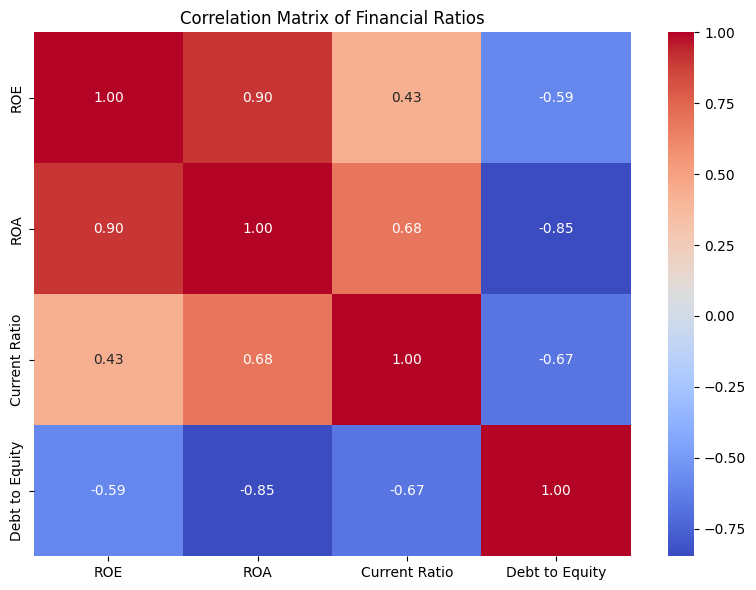

Correlation matrix:
                     ROE       ROA  Current Ratio  Debt to Equity
ROE             1.000000  0.904993       0.434116       -0.592246
ROA             0.904993  1.000000       0.684755       -0.847230
Current Ratio   0.434116  0.684755       1.000000       -0.671542
Debt to Equity -0.592246 -0.847230      -0.671542        1.000000


In [ ]:
# Financial ratio data for LVMH and competitors
data = {
    "Company": [
        "Hermes", "Hermes", "Hermes", "Hermes",
        "Kering", "Kering", "Kering", "Kering",
        "L'Oreal", "L'Oreal", "L'Oreal", "L'Oreal",
        "LVMH", "LVMH", "LVMH", "LVMH",
        "Pernod Ricard", "Pernod Ricard", "Pernod Ricard", "Pernod Ricard"
    ],
    "Year": [2021, 2022, 2023, 2024] * 5,
    "ROE": [0.259637, 0.282419, 0.307095, 0.265069,
            0.195434, 0.232039, 0.178139, 0.066565,
            0.19485, 0.20991, 0.21264, 0.193441,
            0.24609, 0.248816, 0.242006, 0.184011,
            0.087336, 0.126995, 0.153328, 0.087873],
    "ROA": [0.177, 0.193, 0.211, 0.199,
            0.102, 0.106, 0.072, 0.026,
            0.107, 0.122, 0.119, 0.114,
            0.106, 0.105, 0.106, 0.081,
            0.041, 0.055, 0.060, 0.038],
    "Current Ratio": [3.43, 3.94, 4.40, 4.26,
                      1.30, 1.37, 1.28, 1.21,
                      0.73, 1.00, 1.10, 1.13,
                      1.23, 1.26, 1.32, 1.41,
                      2.45, 1.95, 1.73, 1.86],
    "Debt to Equity": [0.470851, 0.41956, 0.373415, 0.331795,
                       1.066519, 1.230048, 1.463358, 1.622466,
                       0.823195, 0.722308, 0.783079, 0.700743,
                       1.562126, 1.378736, 1.291734, 1.153218,
                       1.142398, 1.257174, 1.254029, 1.332857]
}

# Create the DataFrame
df = pd.DataFrame(data)

# Select only ratio columns
ratios_df = df[["ROE", "ROA", "Current Ratio", "Debt to Equity"]]

# Compute correlation matrix
correlation_matrix = ratios_df.corr()

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix of Financial Ratios")
plt.tight_layout()
plt.show()

# Print the matrix
print("Correlation matrix:")
print(correlation_matrix)


# Stock Market Performance

     Date   LVMH  Kering  Hermes  Pernod Ricard  L'Oreal   CAC 40
0   44197  49.71  541.60   842.6         155.70   290.10  5399.21
1   44228  51.64  524.90   923.2         157.35   302.80  5703.22
2   44256  54.88  588.60   944.0         160.05   326.80  6067.23
3   44287  54.28  666.50  1044.0         170.70   341.65  6269.48
4   44317  53.69  748.30  1152.5         180.15   368.30  6447.17
5   44348  56.89  737.00  1228.5         187.20   375.80  6507.83
6   44378  59.25  756.20  1289.0         186.10   385.90  6612.76
7   44409  61.95  674.00  1244.5         177.95   396.30  6680.18
8   44440  61.87  616.00  1196.5         190.70   356.85  6520.01
9   44470  72.74  648.20  1370.5         198.70   394.95  6830.34
10  44501  61.31  681.40  1653.0         202.50   397.50  6721.16
11  44531  62.51  706.90  1536.0         211.50   416.95  7153.03
12  44562  56.47  656.30  1318.5         189.00   376.85  6999.20
13  44593  48.21  637.10  1242.0         195.65   355.00  6658.83
14  44621 

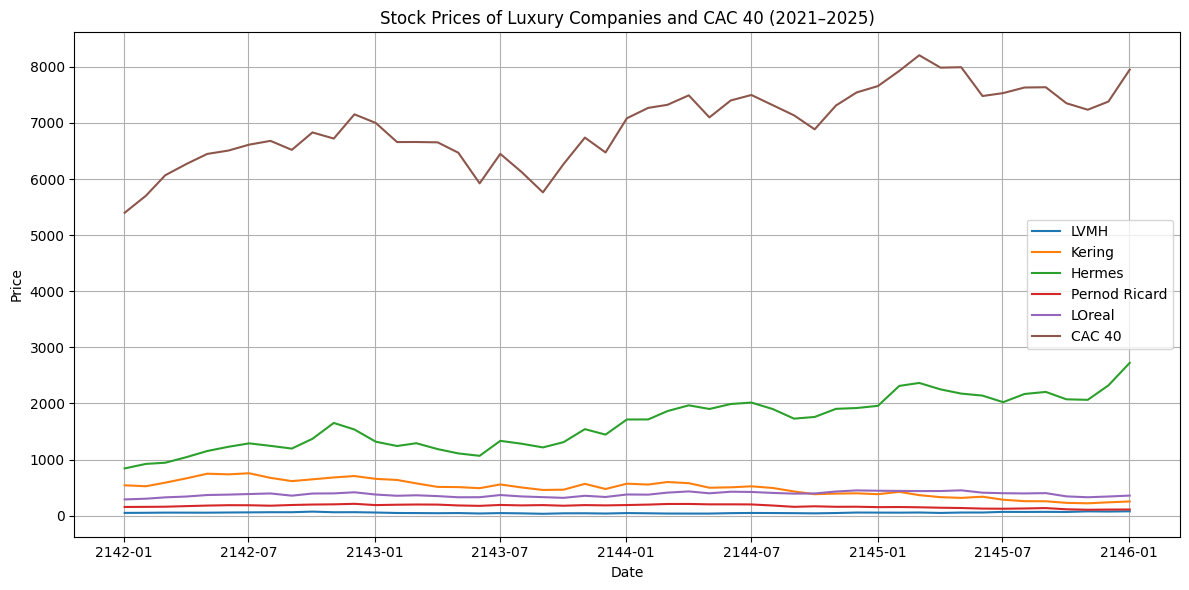

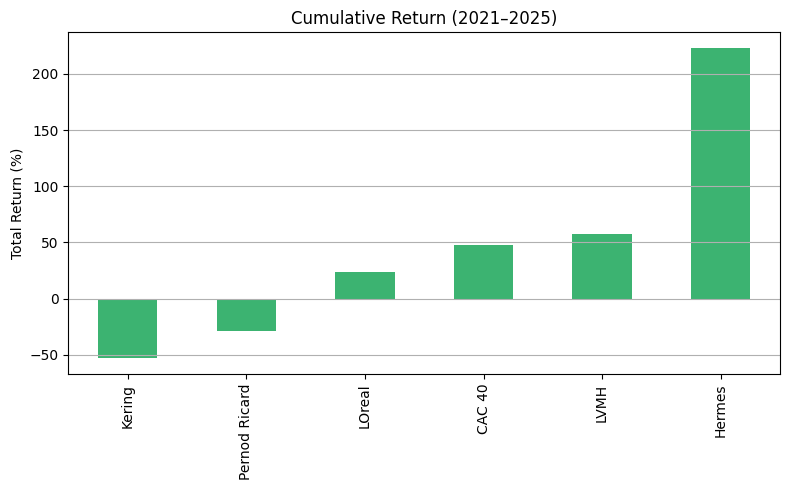

interactive(children=(SelectMultiple(description='Companies:', index=(0,), options=('LVMH', 'Kering', 'Hermes'…

interactive(children=(Dropdown(description='Entreprise', options=('LVMH', 'Kering', 'Hermes', 'Pernod Ricard',…

In [ ]:
# Upload Excel file
import pandas as pd
df=pd.read_excel(r'Stock Market Data cac 40.xlsx')
print(df)

# Clean column names and convert date
df.columns = df.columns.str.replace("'", "")  # fix L'Oreal → LOreal
df.rename(columns={"LOreal": "LOreal"}, inplace=True)
df['Date'] = pd.to_datetime(df['Date'], origin='2020-12-30', unit='D')
df.set_index('Date', inplace=True)

# 1. Plot stock prices
plt.figure(figsize=(12, 6))
for col in df.columns:
    plt.plot(df.index, df[col], label=col)
plt.title("Stock Prices of Luxury Companies and CAC 40 (2021–2025)")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 2. Cumulative return (2021–2025)
returns = df / df.iloc[0] - 1  # (P / P0) - 1
returns_cum = returns.iloc[-1] * 100

plt.figure(figsize=(8, 5))
returns_cum.sort_values().plot(kind='bar', color='mediumseagreen')
plt.title("Cumulative Return (2021–2025)")
plt.ylabel("Total Return (%)")
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

# 3. Annual returns
@interact(companies=widgets.SelectMultiple(options=df.columns, value=['LVMH'], description='Companies:'))
def plot_annual_returns(companies):
    df_yearly = df.resample('Y').last()
    annual_returns = df_yearly.pct_change().dropna() * 100

    plt.figure(figsize=(10, 5))
    for company in companies:  # Plot only selected companies
        plt.plot(annual_returns.index.year, annual_returns[company], marker='o', label=company)
    plt.title("Annual Return by Company")
    plt.xlabel("Year")
    plt.ylabel("Annual Return (%)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# 4. Compare one company vs CAC 40 – dynamique
@interact(
    company=widgets.Dropdown(options=[col for col in df.columns if col != 'CAC 40'], description='Entreprise')
)
def compare_vs_cac(company):
    if 'CAC 40' not in df.columns:
        print("'CAC 40' is missing.")
        return
    company_returns = (df[company] / df[company].iloc[0] - 1) * 100
    cac_returns = (df['CAC 40'] / df['CAC 40'].iloc[0] - 1) * 100

    plt.figure(figsize=(8, 5))
    plt.plot(df.index, company_returns, label=company, color='blue')
    plt.plot(df.index, cac_returns, label='CAC 40', color='orange')
    plt.title(f"{company} vs CAC 40 – Cumulative Return")
    plt.xlabel("Date")
    plt.ylabel("Cumulative Return (%)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()